<body>
<b>the main objective of this analysis is to find the relation between Human time use data from buerau labor statistics and Mosquito blood meal patterns.
  Understanding and finding the hidden patterns of humans' exposure to mosquito bites based on different features (factors) like humans working conditions in indoor/outdoor jobs, based on race and ethnicity background, Gender of human, and Income level of people.</b>
    <br><br>
    In our study, we primarily examined individuals in outdoor jobs. This choice was driven by the understanding that these individuals are more likely to be exposed to mosquito bites than those in indoor occupations.
    <br>
    <ul>
    <li>we use different races like NH white, Hispanic, NH black, and others</li>
    <br>
    <li>Male and female in gender category</li>
    <br>
    <li>income level into low, average, and High-income groups</li>
    <br>
   <li>we mainly concentrated on two mosquito types (Aedes aegypti and Culex quinquefasciatus) as different mosquito species have different preferences for the day/night when they actively seek blood meals.</li>
        </ul>
</body>

## Loading libraries

In [1]:
## IMPORTS
import importlib
import os
from pathlib import Path
import time

import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import IPython 
import lib.utils as _utils
import lib.atus_tools as att
from lib.utils import get_project_logger, config_project_logger, \
    SUCCESS, rotate_ax_labels, get_color_cycle_list, get_x_array_for_barplots

# -------------
_LOGGER = get_project_logger().getChild("ipynb")
# importlib.reload(att)


# %matplotlib widget
# mpl.rcParams["pdf.fonttype"] = 42  # Make text editable in exported pdfs


[atus] DEBUG: `rtrend` Logger configured.


In [2]:
# PARAMETERS
# =========================================

# Preprocessing directory path
# ----------------------------
# --- Baseline 
# preproc_dir = Path("outputs/baseline/by_occupation/")
# preproc_dir = Path("outputs/baseline/by_industry/")
preproc_dir = Path("outputs/baseline/with_bootstrap_100/")

# --- Alternative/sensitivity
# preproc_dir = Path("outputs/alternative/income_classes_20-80_occ/")
# preproc_dir = Path("outputs/alternative/income_classes_20-80_ind/")

# --- Devtests
# preproc_dir = Path("outputs/tests/preproc_dev/")
## comment test
# Mosquito diel activity
# ----------------------
mosq_count_fname = Path("mosquito_diel_data/mosqdiel_general_counts.csv")

In [5]:
def count_folders(directory):
    # Initialize a counter for folders
    folder_count = 0
    
    # Iterate over each item in the directory
    for item in os.listdir(directory):
        # Check if the item is a folder
        if os.path.isdir(os.path.join(directory, item)):
            # If it's a folder, increment the counter
            folder_count += 1
    
    return folder_count


def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

## Preprocessing

##### setting up environment and other basic variables

In [6]:
hourly = False
# preproc_dir, hourly = Path("outputs/tests/main_bootstrap_test/"), False
preproc_dir, hourly = preproc_dir, True


# aggr_features = ["all", "income_id"]
# ------------
aggr_features=[
        "all", "income_id", "TUMONTH", "PESEX", "race_ethnicity", 
        "is_outdoor_job",  "is_weekend", "job_and_weekend", "income_and_weekend","sex_and_weekend","raceth_and_weekend",
         "occupation_exposure_id",
    ]

# IMPORT PREPROCESSED DATA
# ========================
importlib.reload(att)

# ---

env = att.get_default_atus_env()

# === Load mosquito diel activity
mosq_diel_df = pd.read_csv(mosq_count_fname, index_col=[0, 1])
mosq_diel_df.columns.name = "hour"

mosq_diel_df #hourly mosquito count for different locations

env = att.get_default_atus_env()

# Load original ensemble
main_pre = att.ATUSPreprocBunch.from_dir(
    preproc_dir, aggr_features=aggr_features,
    import_raw=False,
    raise_on_not_found=False,
    tseries_is_hourly=hourly,
    
)

In [7]:
# === Create ATUS environment
fname = main_pre.meta_dict.get("atus_environment_path", None)
if fname is not None:
    myenv = att.ATUSEnvironment.from_env_file(fname)
else:
    _LOGGER.warn("No ATUS env path in metadata. Will create default environment.")
    myenv = att.get_default_atus_env()
    
# === Load state metadata
fips_df = att.import_fips_df(main_pre.meta_dict["fips_fname"])

# ---
main_pre.meta_dict["use_aggr_features"]

['all',
 'PESEX',
 'TUMONTH',
 'is_weekend',
 'race_ethnicity',
 'income_id',
 'occupation_exposure_id',
 'is_outdoor_job',
 {'job_and_weekend': ['is_outdoor_job', 'is_weekend']},
 {'income_and_weekend': ['income_id', 'is_weekend']},
 {'raceth_and_weekend': ['race_ethnicity', 'is_weekend']},
 {'sex_and_weekend': ['PESEX', 'is_weekend']}]

## loading bootstrap data into data frames

##### Loading all the Data into multi-index data frame

##### this is how entire data of humans lookslike
each column in data from fifth column is each hour of day and their exposure 

<li>i_boot: is the experiment number</li>
<li>exp_id: is exposure at that time if they are indoor or outdoor</li>
<li>all: is including all features available</li>

In [10]:
boot_df

2023-01-01 00:00:00  2023-01-01 01:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.992003             0.994709   
              Alaska        True             1.000000             0.996233   
              Arizona       True             0.980498             0.984619   
              Arkansas      True             0.983057             0.990840   
              California    True             0.980852             0.986388   
...                                               ...                  ...   
99     2      Virginia      True             0.020948             0.019635   
              Washington    True             0.014276             0.011419   
              West Virginia True             0.028590             0.010801   
              Wisconsin     True             0.024790             0.019661   
              Wyoming       True             0.016121             0.005374   

                                  2023-01-01 02:00:00  2023-01-01 03:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.994570             0.991746   
              Alaska        True             1.000000             1.000000   
              Arizona       True             0.985288             0.983310   
              Arkansas      True             0.997904             0.997259   
              California    True             0.990805             0.989254   
...                                               ...                  ...   
99     2      Virginia      True             0.015993             0.011331   
              Washington    True             0.009219             0.007146   
              West Virginia True             0.010796             0.006759   
              Wisconsin     True             0.013481             0.012551   
              Wyoming       True             0.000000             0.018815   

                                  2023-01-01 04:00:00  2023-01-01 05:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.982672             0.966464   
              Alaska        True             0.976880             0.970829   
              Arizona       True             0.980919             0.961787   
              Arkansas      True             0.987528             0.971772   
              California    True             0.984261             0.961268   
...                                               ...                  ...   
99     2      Virginia      True             0.021152             0.028394   
              Washington    True             0.007063             0.018124   
              West Virginia True             0.020064             0.029429   
              Wisconsin     True             0.013427             0.025224   
              Wyoming       True             0.010311             0.038351   

                                  2023-01-01 06:00:00  2023-01-01 07:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.935649             0.890246   
              Alaska        True             0.972638             0.940053   
              Arizona       True             0.921470             0.881676   
              Arkansas      True             0.926141             0.854593   
              California    True             0.917096             0.858182   
...                                               ...                  ...   
99     2      Virginia      True             0.037860             0.079013   
              Washington    True             0.048375             0.085822   
              West Virginia True             0.064094             0.090319   
              Wisconsin     True             0.067994             0.119721   
              Wyoming       True             0.070446

In [23]:
# # ====================================
# # SELECTABLE FEATURE – Time series
# # ====================================
# exp_id = 1  # Outdoor only

# # feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# # feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# # feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# # feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# # feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# # feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# # --- Composite features
# # feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# # feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# # feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# # feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# # feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

# main_df = main_pre.feat_aggr_df_dict[feat_name]
# if hourly:
#     main_df.columns.name = "hour"
# else:
#     main_df = att.aggregate_exp_minutes_to_hours(df)

# main_df_wted = att.aggregate_states_series_with_weights(
#     main_df, main_pre.slice_data_df["weight"], 
# #     use_level_values=["California", "Florida", "Texas"],
# #     use_level_values=["Florida"],
# )

# boot_df = pd.concat(
#     [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
#     axis=0,
#     keys=samples,
#     names=["i_boot"],
# )

# if hourly:
#     boot_df.columns.name = "hour"
# else:
#     boot_df = att.aggregate_exp_minutes_to_hours(df)

# boot_df_wted = att.aggregate_states_series_with_weights(
#     boot_df, main_pre.slice_data_df["weight"], 
# #     use_level_values=["California", "Florida", "Texas"],
# #     use_level_values=["Florida"],
# )


# boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
# boot_df_mean=boot_df_grp.groupby(['race_ethnicity','is_weekend']).mean().T.sum().to_frame().unstack()

# bootstraped=boot_df_grp.T.sum().to_frame()
# bootstraped.rename(columns={0:'valu'},inplace=True)


# df=bootstraped.reset_index()
# mapping={True:'weekend',False:'weekeday'}
# df['weeker']=df['is_weekend'].map(mapping)
# df['race_ethnicity']=df['race_ethnicity'].map(id_to_name)
# # df['weeker']=df['weeker'].astype('category')
# sns.barplot(data=df,x='race_ethnicity',y='valu',hue='weeker',estimator=np.mean)
# plt.ylabel("avg num of hours spent outside")
# # display(samples_df)

## figure 1

#### mosq randomization using poission for Quinque and ageptyi

In [11]:
# Test mosquito diel data uncertainty
# ==================================
# --- Parameters
# num_samples = 100  # Must match the number of bootstrap samples

num_samples = num_folders # calculated from the UDF for bootstrap data (based on number of bootstrap samples)

# data_label = "miami-aegypti"
# data_label = "brownsville-quinque"
data_labels=["locations-aegypti","brownsville-quinque"]

zero_shift = 5  # Force data to have at least this number of mosquitoes

# ============

def random_mosq_genrator_poission(mosq_diel_df,mosq_label):
    """/*#*********************
    this function uses the provided data frame and mosq_label to generate random mosq for the label
    and returns the dataframe
    */"""
    # --- Select a single mosquito diel data (sum over all months)
    mosq_sr = mosq_diel_df.groupby("data_label").sum().loc[mosq_label]
    # --- Add a shift to small values
    mosq_sr.loc[:] = np.maximum(mosq_sr.values, zero_shift)

    # --- Generate uncertainty for all hours
    rng = np.random.default_rng(seed=1)
    rnd_mosq_array = rng.poisson(mosq_sr.values, size=(num_samples, mosq_sr.shape[0]))
    #  ^ ^ Signature: rnd_mosq_array[i_sample, i_hour] = value
    
    # --- Turn into a data frame
    rnd_mosq_df = pd.DataFrame(rnd_mosq_array)
    rnd_mosq_df.index.name = "sample"
    rnd_mosq_df.columns.name = "hour"

    return rnd_mosq_df


# random mosquito generation for each type of mosquito
df_rnd_mosq_ageypti=random_mosq_genrator_poission(mosq_diel_df,"locations-aegypti")
df_rnd_mosq_quinque=random_mosq_genrator_poission(mosq_diel_df,"brownsville-quinque")
    
#  ^ ^ Signature: rnd_mosq_df.loc[i_sample, i_hour] = value
	
#row-each sample
# column each hor
# RESULT: the `rnd_mosq_df` dataframe contains an ensemble of 
#  diel activity values for each hour. You can use it to generate
#  the figures of the paper.

#### we sampled the data using bootstrap for mosquito populations for 24 hrs of the day

In [12]:
df_rnd_mosq_ageypti

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
sample,,,,,,,,,,,,,,,,,,,,,
0,152,149,153,125,155,97,221,1044,1043,834,...,119,170,195,395,754,1349,1750,828,210,171
1,167,173,132,128,159,93,212,1134,1082,826,...,127,167,197,384,705,1294,1786,826,244,199
2,153,147,131,130,142,107,234,1108,1069,771,...,122,149,176,390,707,1351,1775,775,210,174
3,148,161,141,120,156,106,225,1111,1044,846,...,118,184,206,396,748,1352,1804,731,233,169
4,137,147,112,112,144,107,260,1041,1022,791,...,103,160,187,379,753,1290,1834,776,218,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,133,147,138,120,139,92,228,1050,1018,839,...,138,185,206,348,726,1350,1775,804,228,192
96,160,172,141,123,151,110,206,1087,1010,885,...,116,175,190,403,747,1320,1780,805,239,191
97,146,172,151,133,146,90,227,1094,1058,795,...,111,167,199,399,757,1351,1775,764,209,187


In [15]:
def mosq_uncertainity_plot(mosq_diel_df,mosq_label,rnd_mosq_df):
    mosq_sr = mosq_diel_df.groupby("data_label").sum().loc[mosq_label]
    # --- Add a shift to small values
    mosq_sr.loc[:] = np.maximum(mosq_sr.values, zero_shift)
    fig, ax = plt.subplots()
    
    # --- Generated uncertainty 
    ax.plot(rnd_mosq_df.mean(axis=0), label="mean")
    ax.fill_between(
        x=rnd_mosq_df.columns,  # Hours
        y1=rnd_mosq_df.quantile(q=0.025),  # Lower quantile
        y2=rnd_mosq_df.quantile(q=0.975),  # Upper quantile
        # Formatting options
        alpha=0.5, color="C1", linewidth=0,
    )
    
    # --- Original data: mosquito diel activity without uncertainty
    # ax.plot(mosq_sr, label="Original data")
    
    
    ax.legend()


    return fig, ax
    

### before normalization

##### this is number of ageptyi mosquito moment patterns in each hour of the day with shaded are being confidence intervals

<body><li>it implies that these species are mostly active in the morning around 8:00 am to 10:00 am and late in the evening 7:00 pm to 10:00 pm</li></body>

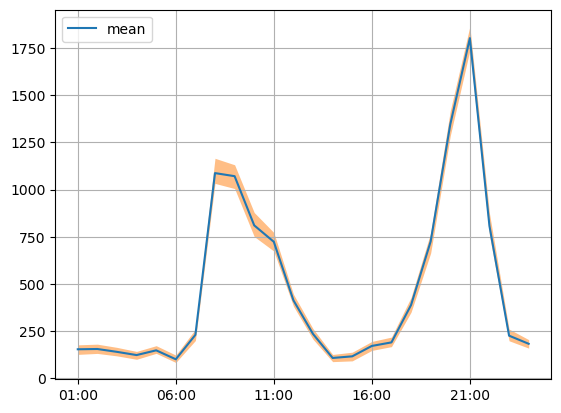

<Figure size 2000x1500 with 0 Axes>

In [16]:
do_save_fig=False

fig, ax = mosq_uncertainity_plot(mosq_diel_df,"locations-aegypti",df_rnd_mosq_ageypti)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.grid(True)
plt.figure(figsize=(20,15))
plt.show()  # If you want to display the plot

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig1_locations_aegypti.pdf")

##### normailizing the population

### ageptyi post normalization

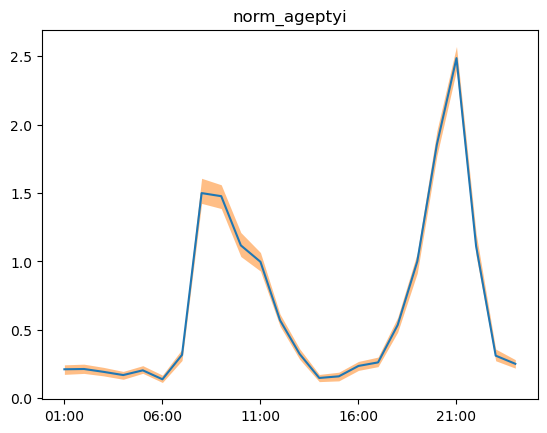

<Figure size 2000x1500 with 0 Axes>

Folder 'tmp_figs/preprint' already exists.


In [17]:
temp_val=df_rnd_mosq_ageypti.mean(axis=0).loc[18] ## 6pm value
norm_df_rnd_mosq_ageypti=df_rnd_mosq_ageypti/temp_val

do_save_fig=True

fig, ax = mosq_uncertainity_plot(mosq_diel_df,"locations-aegypti",norm_df_rnd_mosq_ageypti)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title("norm_ageptyi")
# plt.grid(True)
plt.gca().legend().remove() 
plt.figure(figsize=(20,15))
plt.show()  # If you want to display the plot

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig1_locations_norm_aegypti.pdf")

### quinque pre normalization

##### this is number of quinque mosquito moment patterns in each hour of the day with shaded are being confidence intervals

<body><li>it implies that these species are mostly active early in the morning and late in the evening</li></body>

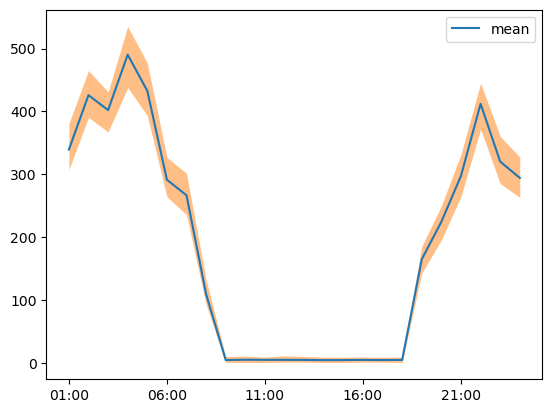

Folder 'tmp_figs/preprint' already exists.


In [18]:
# %matplotlib widget
fig, ax = mosq_uncertainity_plot(mosq_diel_df,"brownsville-quinque",df_rnd_mosq_quinque)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))

plt.show()  # If you want to display the plot

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig1_brownsville-quinque.pdf")

### quinque post normalization

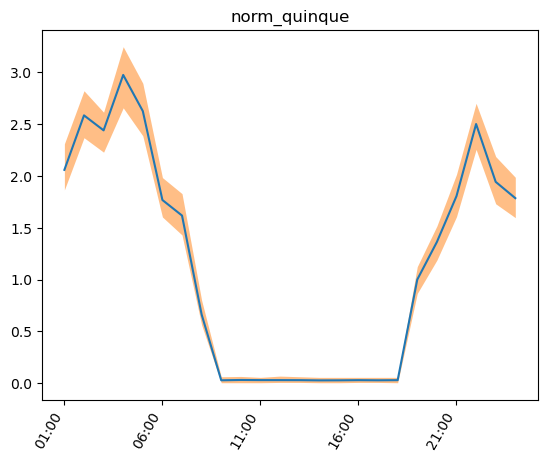

<Figure size 2000x1500 with 0 Axes>

Folder 'tmp_figs/preprint' already exists.


In [19]:
temp_val=df_rnd_mosq_quinque.mean(axis=0).loc[18] ## quinque value at 6pm
norm_df_rnd_mosq_quinque=df_rnd_mosq_quinque/temp_val

do_save_fig=True

fig, ax = mosq_uncertainity_plot(mosq_diel_df,"locations-aegypti",norm_df_rnd_mosq_quinque)
rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))

plt.title("norm_quinque")
# plt.grid(True)
plt.gca().legend().remove() 
plt.figure(figsize=(20,15))
plt.ion()
plt.show()  # If you want to display the plot

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig1_locations_Norm_quinque.pdf")

### Human timeuse timeseries

In [20]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")


##### This is humans time use patterns outdoors. it implies that generally humans more outdoor during the day .

Folder 'tmp_figs/preprint' already exists.


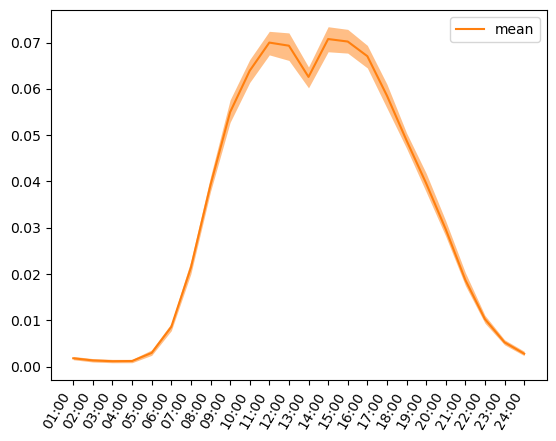

In [22]:
fig, ax = plt.subplots()
    
# --- Generated uncertainty 
ax.plot(boot_df_grp.mean(axis=0), label="mean", color="C1")
ax.fill_between(
    x=boot_df_grp.columns,  # Hours
    y1=boot_df_grp.quantile(q=0.025),  # Lower quantile
    y2=boot_df_grp.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.5, color="C1", linewidth=0,
)
rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt

ax.legend()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig1_human_all.pdf")

In [20]:
hour_list=boot_df_grp.columns.to_list()
hours=[]
for i in range(len(hour_list)):
# Parse the string into a datetime object
    dt_object = datetime.strptime(hour_list[i], "%Y-%m-%d %H:%M:%S")
    # Extract the hour component
    hours.append(dt_object.hour)

## normalizing the mosquito and human crossover

In [21]:
boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"
human_df=boot_df_grp.droplevel("all")


##### normalizing with 6pm value of each mosq_human cross over


human_X_mosq_ageptyi=human_df*df_rnd_mosq_ageypti
human_X_mosq_quinque=human_df*df_rnd_mosq_quinque

## using value at 6pm so commenting max value
# max_human_x_mosq_ageptyi=human_X_mosq_ageptyi.mean(axis=0).max()
# max_human_x_mosq_quinque=human_X_mosq_quinque.mean(axis=0).max()

norm_6_pm_ageptyi=human_X_mosq_ageptyi.mean(axis=0).loc[18]
norm_6_pm_quinque=human_X_mosq_quinque.mean(axis=0).loc[18]

norm_human_X_mosq_ageptyi=human_X_mosq_ageptyi/norm_6_pm_ageptyi 
norm_human_X_mosq_quinque=human_X_mosq_quinque/norm_6_pm_quinque 

In [22]:
norm_6_pm_quinque

6.532225619729022

## figure 2

#### ageptyi and human cross over

Folder 'tmp_figs/preprint' already exists.


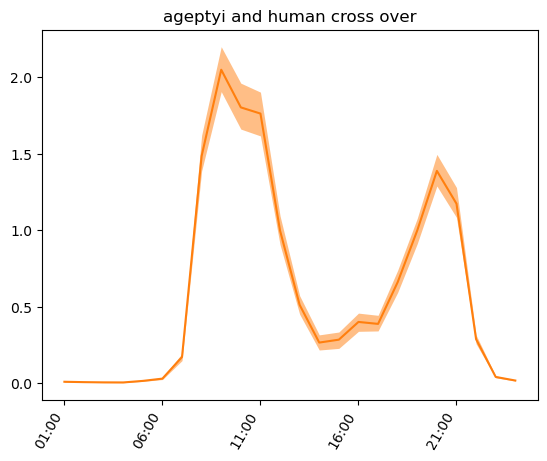

In [24]:
fig, ax = plt.subplots()
    
# --- Generated uncertainty 
ax.plot(norm_human_X_mosq_ageptyi.mean(axis=0), label="mean", color="C1")
ax.fill_between(
    x=norm_human_X_mosq_ageptyi.columns,  # Hours
    y1=norm_human_X_mosq_ageptyi.quantile(q=0.025),  # Lower quantile
    y2=norm_human_X_mosq_ageptyi.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.5, color="C1", linewidth=0,
)

rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title('ageptyi and human cross over')

# ax.legend()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig2_norm_human_X_norm_mosq_ageptyi.pdf")

#### quinque and human cross over

Folder 'tmp_figs/preprint' already exists.


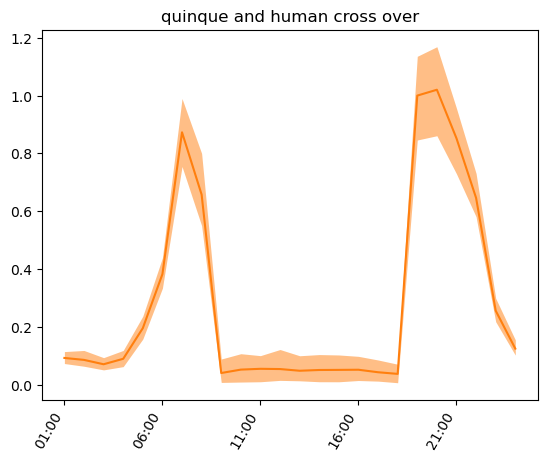

In [25]:
fig, ax = plt.subplots()
    
# --- Generated uncertainty 
ax.plot(norm_human_X_mosq_quinque.mean(axis=0), label="mean", color="C1")
ax.fill_between(
    x=norm_human_X_mosq_quinque.columns,  # Hours
    y1=norm_human_X_mosq_quinque.quantile(q=0.025),  # Lower quantile
    y2=norm_human_X_mosq_quinque.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.5, color="C1", linewidth=0,
)
rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title('quinque and human cross over')

# ax.legend()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/fig2_norm_human_X_norm_mosq_quinque.pdf")

# figure 3

## calculating overall population for normalization

In [26]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"
human_df=boot_df_grp.droplevel("all")


human_X_mosq_ageptyi=human_df*df_rnd_mosq_ageypti
human_X_mosq_quinque=human_df*df_rnd_mosq_quinque


mean_overall_human_pop_with_mosq_ageptyi=human_X_mosq_ageptyi.sum(axis=1).mean()
mean_overall_human_pop_with_mosq_quinque=human_X_mosq_quinque.sum(axis=1).mean()

## with ageptyi

### income_id

In [61]:
mean_overall_human_pop_with_mosq_ageptyi

424.1350491249157

In [62]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)
all_df

,mean_val,lower,upper,feat
0,0.975768,0.044687,0.047678,Low income
1,1.019631,0.043386,0.047949,Middle income
2,1.003594,0.055596,0.051985,High income


#### time series

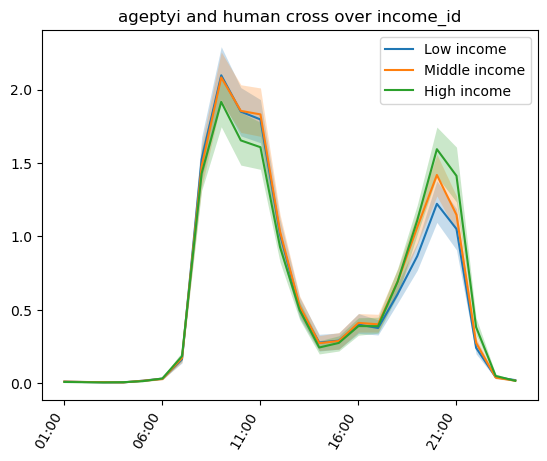

Folder 'tmp_figs/preprint' already exists.


In [63]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)
t_plot=mosq_human_df1/norm_6_pm_ageptyi

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
ax.plot(i2.mean(axis=0), label= map_names[2], color="C2")
ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"ageptyi and human cross over {feat_name}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/ageptyi_{feat_name}_timeseries.pdf")

In [64]:
multi_feat_df=all_df.copy()

### Gender

Folder 'tmp_figs/preprint' already exists.


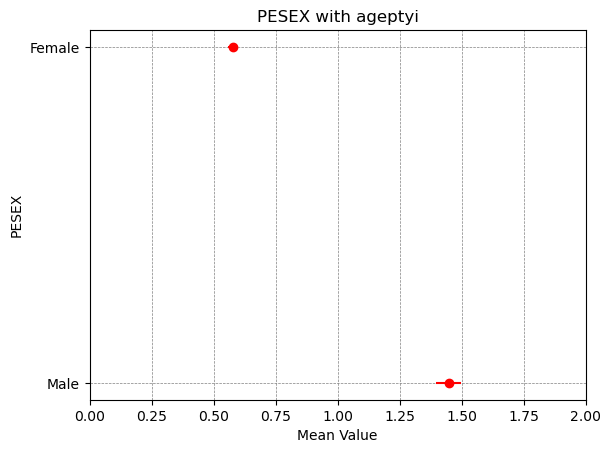

In [65]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_ageypti
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_ageypti_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_ageptyi
con_df=norm_ageypti_human_df.groupby(feat_name).mean()
q_25=norm_ageypti_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_ageypti_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 2)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with ageptyi")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_ageptyi.pdf")


In [66]:
print(norm_ageypti_human_df.groupby(feat_name).mean())
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.025))
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.975))

              0
PESEX          
1      1.451462
2      0.578059
              0
PESEX          
1      1.396267
2      0.556485
              0
PESEX          
1      1.503747
2      0.602069


#### time series

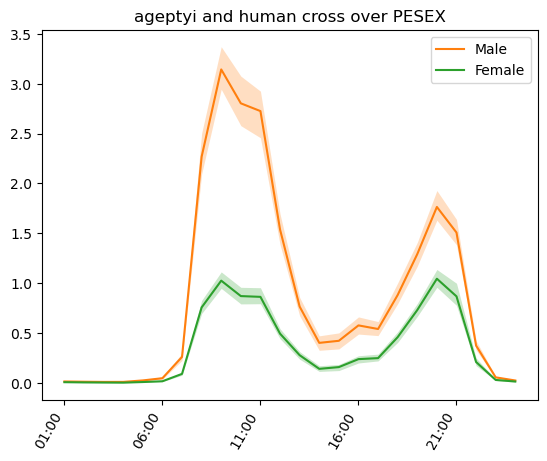

Folder 'tmp_figs/preprint' already exists.


In [67]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)

t_plot=mosq_human_df1/norm_6_pm_ageptyi

# for i in lvls:
# i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
# ax.plot(i0.mean(axis=0), label="mean i0", color="C0")
ax.plot(i1.mean(axis=0), label=map_names[0], color="C1")
ax.plot(i2.mean(axis=0), label=map_names[1], color="C2")
# ax.fill_between(
#     x=i0.columns,  # Hours
#     y1=i0.quantile(q=0.025),  # Lower quantile
#     y2=i0.quantile(q=0.975),  # Upper quantile
#     # Formatting options
#     alpha=0.25, color="C0", linewidth=0,
# )

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"ageptyi and human cross over {feat_name}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/ageptyi_{feat_name}_timeseries.pdf")

In [68]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)

multi_feat_df=pd.concat([multi_feat_df,all_df],ignore_index=True)
multi_feat_df

,mean_val,lower,upper,feat
0,0.975768,0.044687,0.047678,Low income
1,1.019631,0.043386,0.047949,Middle income
2,1.003594,0.055596,0.051985,High income
3,1.451462,0.055195,0.044660,Male
4,0.578059,0.021574,0.017805,Female


### race and ethnicity

Folder 'tmp_figs/preprint' already exists.


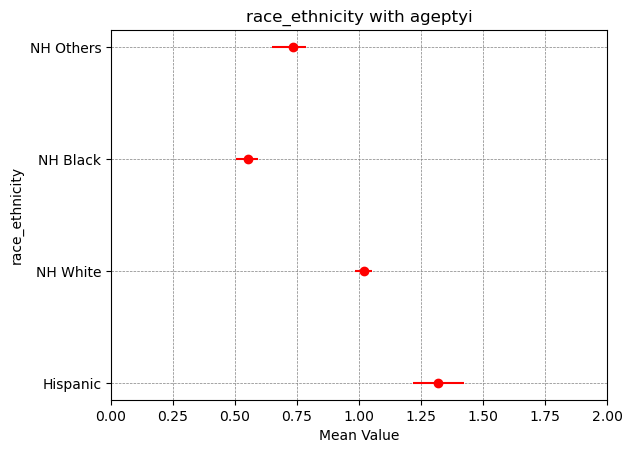

In [69]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_ageypti
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_ageypti_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_ageptyi
con_df=norm_ageypti_human_df.groupby(feat_name).mean()
q_25=norm_ageypti_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_ageypti_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 2)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with ageptyi")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_ageptyi.pdf")

In [38]:
print(norm_ageypti_human_df.groupby(feat_name).mean())
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.025))
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.975))

                       0
race_ethnicity          
0               1.318038
1               1.020166
2               0.552871
3               0.732128
                       0
race_ethnicity          
0               1.217316
1               0.982990
2               0.504463
3               0.647160
                       0
race_ethnicity          
0               1.442923
1               1.061249
2               0.614976
3               0.808584


#### time series

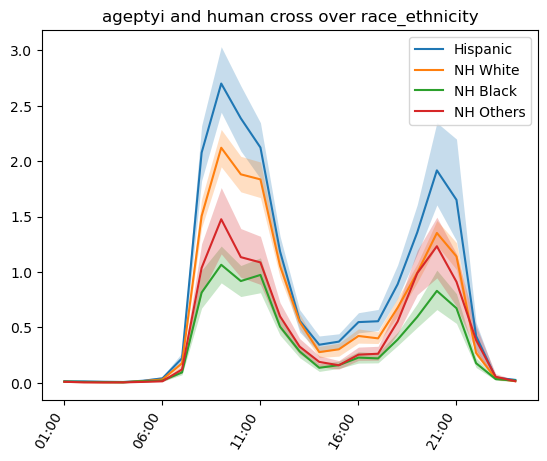

Folder 'tmp_figs/preprint' already exists.


In [70]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)

t_plot=mosq_human_df1/norm_6_pm_ageptyi

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)
i3=t_plot.xs(3,level=feat_name)

fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)

# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
ax.plot(i2.mean(axis=0), label=map_names[2], color="C2")
ax.plot(i3.mean(axis=0), label=map_names[3], color="C3")

ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)

ax.fill_between(
    x=i3.columns,  # Hours
    y1=i3.quantile(q=0.025),  # Lower quantile
    y2=i3.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C3", linewidth=0,
)


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"ageptyi and human cross over {feat_name}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/ageptyi_{feat_name}_timeseries.pdf")

In [71]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)

multi_feat_df=pd.concat([multi_feat_df,all_df],ignore_index=True)
multi_feat_df

,mean_val,lower,upper,feat
0,0.975768,0.044687,0.047678,Low income
1,1.019631,0.043386,0.047949,Middle income
2,1.003594,0.055596,0.051985,High income
3,1.451462,0.055195,0.044660,Male
4,0.578059,0.021574,0.017805,Female
5,1.318038,0.100722,0.103246,Hispanic
6,1.020166,0.037176,0.030502,NH White
7,0.552871,0.048407,0.038760,NH Black
8,0.732128,0.084968,0.052949,NH Others


### is_outdoor_job

Folder 'tmp_figs/preprint' already exists.


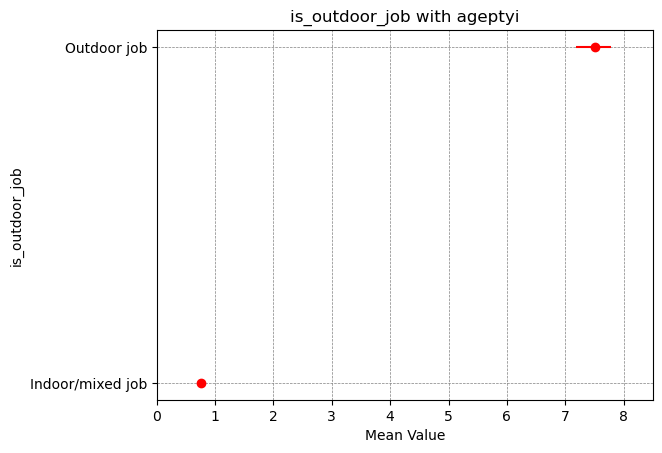

In [72]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_ageypti
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_ageypti_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_ageptyi
con_df=norm_ageypti_human_df.groupby(feat_name).mean()
q_25=norm_ageypti_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_ageypti_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 8.5)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with ageptyi")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

if do_save_fig:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_ageptyi.pdf")

In [73]:
print(norm_ageypti_human_df.groupby(feat_name).mean())
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.025))
print(norm_ageypti_human_df.groupby(feat_name).quantile(q=0.975))

                       0
is_outdoor_job          
0               0.760418
1               7.515855
                       0
is_outdoor_job          
0               0.735804
1               7.181385
                       0
is_outdoor_job          
0               0.785977
1               7.844468


#### timeseries

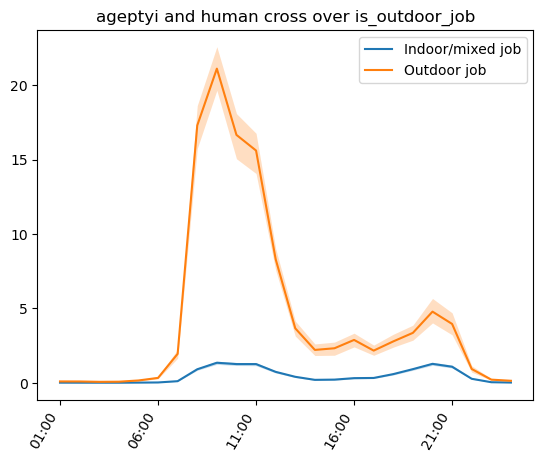

Folder 'tmp_figs/preprint' already exists.


In [74]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)

t_plot=mosq_human_df1/norm_6_pm_ageptyi

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
# i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()
map_names=lvls.map(id_to_name)

# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
# ax.plot(i2.mean(axis=0), label="mean i2", color="C2")
ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

# ax.fill_between(
#     x=i2.columns,  # Hours
#     y1=i2.quantile(q=0.025),  # Lower quantile
#     y2=i2.quantile(q=0.975),  # Upper quantile
#     # Formatting options
#     alpha=0.25, color="C2", linewidth=0,
# )


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"ageptyi and human cross over {feat_name}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/ageptyi_{feat_name}_timeseries.pdf")

In [75]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)

multi_feat_df=pd.concat([multi_feat_df,all_df],ignore_index=True)
multi_feat_df

,mean_val,lower,upper,feat
0,0.975768,0.044687,0.047678,Low income
1,1.019631,0.043386,0.047949,Middle income
2,1.003594,0.055596,0.051985,High income
3,1.451462,0.055195,0.044660,Male
4,0.578059,0.021574,0.017805,Female
5,1.318038,0.100722,0.103246,Hispanic
6,1.020166,0.037176,0.030502,NH White
7,0.552871,0.048407,0.038760,NH Black
8,0.732128,0.084968,0.052949,NH Others
9,0.760418,0.024613,0.016989,Indoor/mixed job


## ageptyi multi features

Folder 'tmp_figs/preprint' already exists.


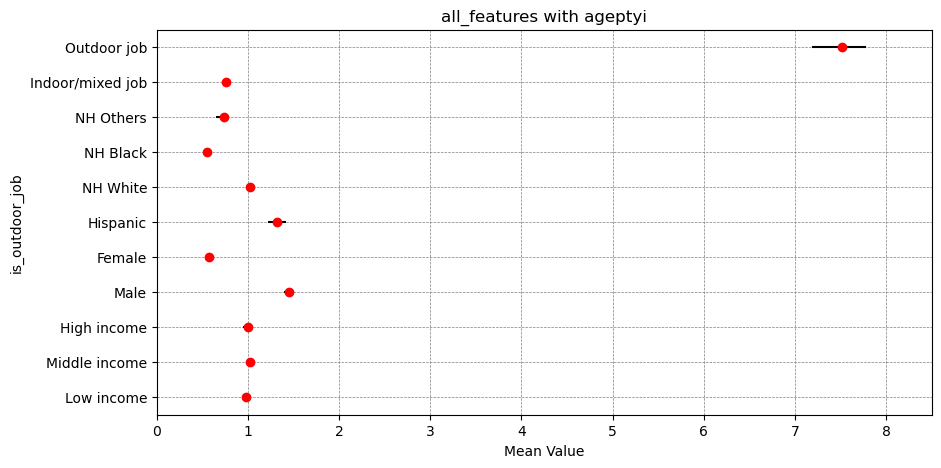

In [83]:
asymentric_err_bar=[multi_feat_df['lower'].values,multi_feat_df['upper'].values]


fig,ax=plt.subplots(figsize=(10,5))

ax.errorbar(y=multi_feat_df['feat'], x=multi_feat_df['mean_val'],xerr=asymentric_err_bar,ecolor='black', color='red',fmt="o")

ax.set_xlim(0, 8.5)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"all_features with ageptyi")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)



create_folder_if_not_exists('tmp_figs/preprint')
plt.savefig(f"tmp_figs/preprint/multi_features_with_ageptyi.pdf")

## with quinque

### incomeID

Folder 'tmp_figs/preprint' already exists.


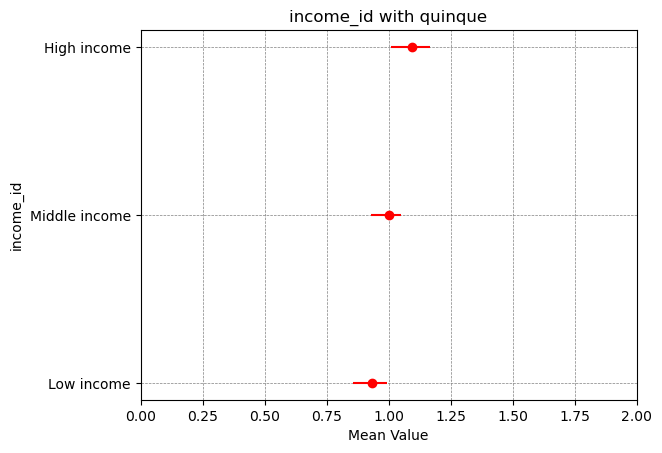

In [92]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_quinque
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_quinque_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_quinque
con_df=norm_quinque_human_df.groupby(feat_name).mean()
q_25=norm_quinque_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_quinque_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 2)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with quinque")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

create_folder_if_not_exists('tmp_figs/preprint')
plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_quinque.pdf")

#### timeseries

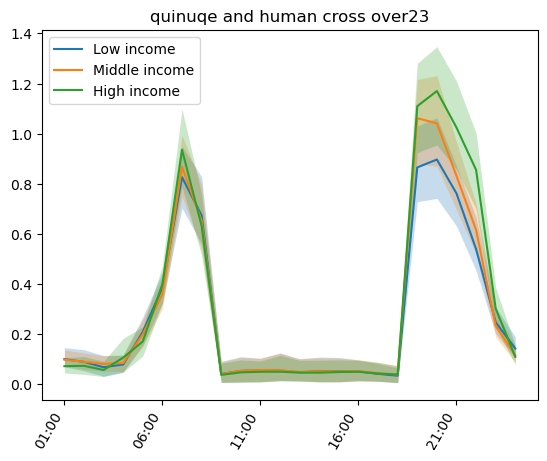

Folder 'tmp_figs/preprint' already exists.


In [93]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)
t_plot=mosq_human_df1/norm_6_pm_quinque

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
ax.plot(i2.mean(axis=0), label= map_names[2], color="C2")
ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"quinuqe and human cross over{i}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/quinque_{feat_name}_timeseries.pdf")

In [94]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)
all_df

multi_feat_df_quinque=all_df.copy()
multi_feat_df_quinque

,mean_val,lower,upper,feat
0,0.933387,0.076457,0.060683,Low income
1,1.000632,0.072274,0.048337,Middle income
2,1.095177,0.085334,0.072183,High income


### Gender

Folder 'tmp_figs/preprint' already exists.


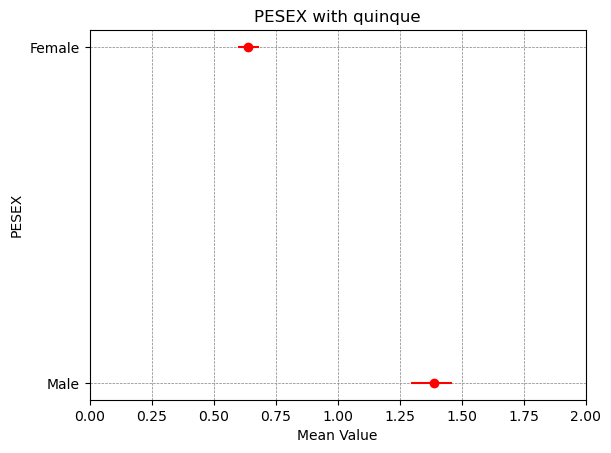

In [95]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_quinque
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_quinque_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_quinque
con_df=norm_quinque_human_df.groupby(feat_name).mean()
q_25=norm_quinque_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_quinque_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 2)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with quinque")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()


create_folder_if_not_exists('tmp_figs/preprint')
plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_quinque.pdf")

In [96]:
print(norm_quinque_human_df.groupby(feat_name).mean())
print(norm_quinque_human_df.groupby(feat_name).quantile(q=0.025))
print(norm_quinque_human_df.groupby(feat_name).quantile(q=0.975))

              0
PESEX          
1      1.387253
2      0.639979
              0
PESEX          
1      1.295329
2      0.596812
              0
PESEX          
1      1.484680
2      0.694078


#### timeserires

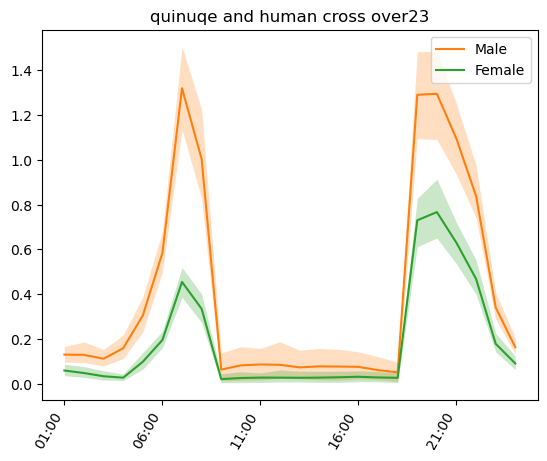

Folder 'tmp_figs/preprint' already exists.


In [97]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)
t_plot=mosq_human_df1/norm_6_pm_quinque

# for i in lvls:
# i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
# ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[0], color="C1")
ax.plot(i2.mean(axis=0), label= map_names[1], color="C2")
# ax.fill_between(
#     x=i0.columns,  # Hours
#     y1=i0.quantile(q=0.025),  # Lower quantile
#     y2=i0.quantile(q=0.975),  # Upper quantile
#     # Formatting options
#     alpha=0.25, color="C0", linewidth=0,
# )

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"quinuqe and human cross over{i}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/quinque_{feat_name}_timeseries.pdf")

In [98]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)

multi_feat_df_quinque=pd.concat([multi_feat_df_quinque,all_df],ignore_index=True)
multi_feat_df_quinque

,mean_val,lower,upper,feat
0,0.933387,0.076457,0.060683,Low income
1,1.000632,0.072274,0.048337,Middle income
2,1.095177,0.085334,0.072183,High income
3,1.387253,0.091923,0.074613,Male
4,0.639979,0.043167,0.043183,Female


### Race and ethnicity

Folder 'tmp_figs/preprint' already exists.


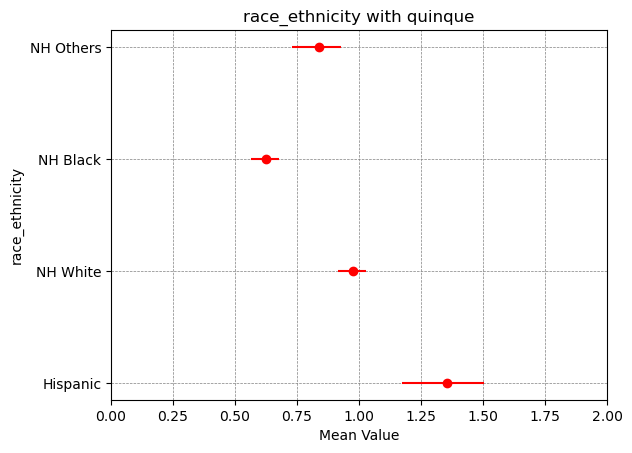

In [99]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_quinque
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_quinque_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_quinque
con_df=norm_quinque_human_df.groupby(feat_name).mean()
q_25=norm_quinque_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_quinque_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 2)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with quinque")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

create_folder_if_not_exists('tmp_figs/preprint')
plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_quinque.pdf")

In [100]:
print(norm_quinque_human_df.groupby(feat_name).mean())
print(norm_quinque_human_df.groupby(feat_name).quantile(q=0.025))
print(norm_quinque_human_df.groupby(feat_name).quantile(q=0.975))

                       0
race_ethnicity          
0               1.355322
1               0.974610
2               0.626453
3               0.839486
                       0
race_ethnicity          
0               1.171266
1               0.915995
2               0.564840
3               0.729303
                       0
race_ethnicity          
0               1.558593
1               1.037228
2               0.706915
3               0.948402


#### timeseries

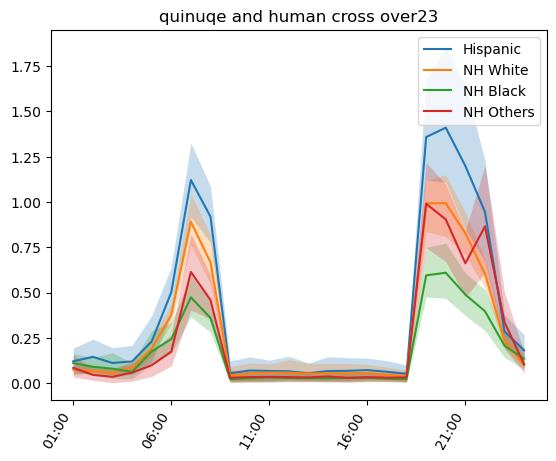

Folder 'tmp_figs/preprint' already exists.


In [101]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)
t_plot=mosq_human_df1/norm_6_pm_quinque

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
i2=t_plot.xs(2,level=feat_name)
i3=t_plot.xs(3,level=feat_name)

fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
ax.plot(i2.mean(axis=0), label= map_names[2], color="C2")
ax.plot(i3.mean(axis=0), label= map_names[3], color="C3")
ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

ax.fill_between(
    x=i2.columns,  # Hours
    y1=i2.quantile(q=0.025),  # Lower quantile
    y2=i2.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C2", linewidth=0,
)

ax.fill_between(
    x=i3.columns,  # Hours
    y1=i3.quantile(q=0.025),  # Lower quantile
    y2=i3.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C3", linewidth=0,
)

rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"quinuqe and human cross over{i}")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/quinque_{feat_name}_timeseries.pdf")

In [102]:
all_df['feat']=all_df[feat_name]
all_df.drop(feat_name,inplace=True,axis=1)

multi_feat_df_quinque=pd.concat([multi_feat_df_quinque,all_df],ignore_index=True)
multi_feat_df_quinque

,mean_val,lower,upper,feat
0,0.933387,0.076457,0.060683,Low income
1,1.000632,0.072274,0.048337,Middle income
2,1.095177,0.085334,0.072183,High income
3,1.387253,0.091923,0.074613,Male
4,0.639979,0.043167,0.043183,Female
5,1.355322,0.184056,0.146935,Hispanic
6,0.974610,0.058615,0.052484,NH White
7,0.626453,0.061613,0.050900,NH Black
8,0.839486,0.110183,0.088742,NH Others


#### is_outdoor_job

Folder 'tmp_figs/preprint' already exists.


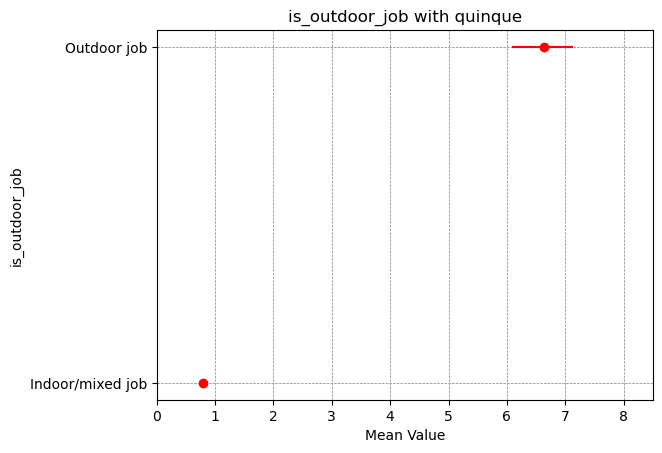

In [103]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_grp.columns=hours
boot_df_grp.columns.name = "hour"

lvls=boot_df_grp.index.get_level_values(feat_name).unique()
mosq_type_df=df_rnd_mosq_quinque
mosq_human_df=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df).sum(axis=1) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
).to_frame()

norm_quinque_human_df=mosq_human_df/mean_overall_human_pop_with_mosq_quinque
con_df=norm_quinque_human_df.groupby(feat_name).mean()
q_25=norm_quinque_human_df.groupby(feat_name).quantile(0.025)
q_95=norm_quinque_human_df.groupby(feat_name).quantile(0.925)

con_df['mean_val']=con_df[0]
q_25['q25']=q_25[0]
q_95['q95']=q_95[0]

con_df.drop(0,inplace=True,axis=1)
q_25.drop(0,inplace=True,axis=1)
q_95.drop(0,inplace=True,axis=1)

quantile=pd.merge(q_95,q_25,how='inner',on=feat_name)
# quantile['diff']=quantile['q95']-quantile['q25']

# quantile.drop(columns=['q25','q95'],inplace=True)

all_df=pd.merge(con_df,quantile,how='inner',on=feat_name)
all_df['lower']=all_df['mean_val']-all_df['q25']
all_df['upper']=all_df['q95']-all_df['mean_val']
all_df.drop(columns=['q25','q95'],inplace=True)
asymentric_err_bar=[all_df['lower'].values,all_df['upper'].values]


all_df=all_df.T

all_df.columns=all_df.columns.map(id_to_name)
all_df=all_df.T
all_df=all_df.reset_index()

fig,ax=plt.subplots()
ax.errorbar(y=all_df[feat_name], x=all_df['mean_val'],xerr=asymentric_err_bar, color='red',fmt="o")

ax.set_xlim(0, 8.5)

ax.set_xlabel('Mean Value')
ax.set_ylabel(feat_name)
ax.set_title(f"{feat_name} with quinque")
# Customizing grid lines
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)
fig.show()

create_folder_if_not_exists('tmp_figs/preprint')
plt.savefig(f"tmp_figs/preprint/fig3_{feat_name}_with_quinque.pdf")

#### timeseries

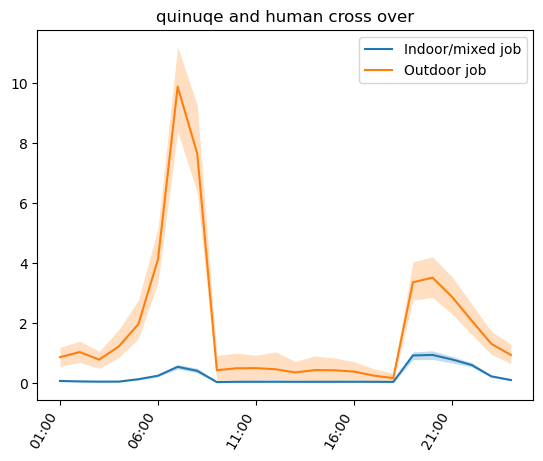

Folder 'tmp_figs/preprint' already exists.


In [105]:
mosq_human_df1=pd.concat(
    [boot_df_grp.xs(i,level=feat_name).mul(mosq_type_df) for i in lvls],
    axis=0,
    keys=lvls,
    names=[feat_name],
)
t_plot=mosq_human_df1/norm_6_pm_quinque

# for i in lvls:
i0=t_plot.xs(0,level=feat_name)
i1=t_plot.xs(1,level=feat_name)
# i2=t_plot.xs(2,level=feat_name)


fig, ax = plt.subplots()

map_names=lvls.map(id_to_name)
# --- Generated uncertainty 
ax.plot(i0.mean(axis=0), label=map_names[0], color="C0")
ax.plot(i1.mean(axis=0), label=map_names[1], color="C1")
# ax.plot(i2.mean(axis=0), label= map_names[2], color="C2")
ax.fill_between(
    x=i0.columns,  # Hours
    y1=i0.quantile(q=0.025),  # Lower quantile
    y2=i0.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C0", linewidth=0,
)

ax.fill_between(
    x=i1.columns,  # Hours
    y1=i1.quantile(q=0.025),  # Lower quantile
    y2=i1.quantile(q=0.975),  # Upper quantile
    # Formatting options
    alpha=0.25, color="C1", linewidth=0,
)

# ax.fill_between(
#     x=i2.columns,  # Hours
#     y1=i2.quantile(q=0.025),  # Lower quantile
#     y2=i2.quantile(q=0.975),  # Upper quantile
#     # Formatting options
#     alpha=0.25, color="C2", linewidth=0,
# )


rotate_ax_labels(ax)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d:%H"))
plt.title(f"quinuqe and human cross over")

ax.legend()
plt.show()
if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    fig.savefig(f"tmp_figs/preprint/quinque_{feat_name}_timeseries.pdf")